In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


## Load Dataset

In [2]:
df = pd.read_excel(r"C:\Users\Admin\Documents\Studio Code\startup_partnerships\Germany Startups Dataset.xlsx", sheet_name='Encoded')
df

,No.,Company,Industry,AdTech,Cybersecurity,Digital Health,Digital Chemistry,E-Commerce,Education,FinTech,...,num_headquart,dist_bin,dist_bin_no,Startup founders,num_of_founder,num_of_female,percent_female,Website,Email,high_potential
0,1,1A Robotics,Cross-industry,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,Very Close,1,Manquel Tejeda Neira,1,0,0.0,http://www.1arobotics.com,manquel(at)(one)arobotics.com,0
1,2,2VizCon,"MediaTech, Education, E-Commerce",0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,Very Close,1,"Walter Scheuer, Oliver Turnbull, Wryland Reed",3,0,0.0,https://2viz.io,walter(at)(two)viz.io,0
2,3,3dvisionlabs GmbH,Smart Systems,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,Far,4,"Dr. Michel Findeisen, Lars Meinel, Markus Hess",3,0,0.0,https://3dvisionlabs.com/,info(at)(three)dvisionlabs.com,0
3,4,4mobil,SaaS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,Commutable,3,Sakir Kürt,1,0,0.0,https://4mobil.de/,sk(at)werkelf.com,0
4,5,Acalta GmbH,"Digital Health, SaaS",0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,Commutable,3,"Frederik Kaul, Nico Ploner, Simon Winkler",3,0,0.0,https://www.acalta.de/,info(at)acalta(dot)de,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,751,Zesavi,"MediaTech, Education, SaaS, Cross-Industry",0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,Far,4,"Maximilian Zeyda, Edwin Sauer",2,0,0.0,https://zesavi.com,founder(at)zesavi(dot)com,0
751,752,ZF Car eWallet GmbH,"Logistics, FinTech, Mobility, Smart Systems, S...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,Far,4,Thorsten Weber + ZF Friedrichshafen AG,2,0,0.0,http://www.car-ewallet.de,thorsten(dot)weber(at)car-ewallet(dot)de,0
752,753,zkSystems,"SaaS, Smart Systems, Smart Infrastructure",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,Far,4,"Diana Rees, CEO, Amine Ünal, CTO",2,1,50.0,http://zksystems.io,info(at)zksystems.io,0
753,754,Zolitron Technology,"Logistics, SaaS",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,Commutable,3,Arndt-Hendrik Zinn,1,0,0.0,https://zolitron.com/,info(at)zolitron(dot)com,1


## Examine the dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 74 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   No.                          755 non-null    int64  
 1   Company                      755 non-null    object 
 2   Industry                     741 non-null    object 
 3   AdTech                       741 non-null    float64
 4   Cybersecurity                741 non-null    float64
 5   Digital Health               741 non-null    float64
 6   Digital Chemistry            741 non-null    float64
 7   E-Commerce                   741 non-null    float64
 8   Education                    741 non-null    float64
 9   FinTech                      741 non-null    float64
 10  InsurTech                    741 non-null    float64
 11  LegalTech                    741 non-null    float64
 12  Logistics                    741 non-null    float64
 13  MediaTech           

In [49]:
df.columns

Index(['AdTech', 'Cybersecurity', 'Digital Health', 'Digital Chemistry',
       'E-Commerce', 'Education', 'FinTech', 'InsurTech', 'LegalTech',
       'Logistics', 'MediaTech', 'Mobility', 'SaaS', 'Smart Infrastructure',
       'Smart Systems', 'Cross-industry', 'Artificial intelligence',
       'Blockchain', 'Robotics', 'Virtual Reality', 'Hardware',
       'Software Development', 'Data Analytics', 'Internet of Things',
       'Partner', 'Financing', 'Talents', 'Mentoring', 'Hub Berlin',
       'Hub Cologne', 'Hub Dresden/Leipzig', 'Hub Dortmund',
       'Hub Frankfurt/Darmstadt', 'Hub Hamburg', 'Hub Karlsruhe',
       'Hub Mannheim/Ludwigshafen', 'Hub Munich', 'Hub Potsdam',
       'Hub Nuremberg/Erlangen', 'Hub Stuttgart',
       'Not part of the network yet', 'num_of_hub', 'b2b', 'b2c', 'size_no',
       'funding_no', 'market_no', 'num_headquart', 'dist_A', 'dist_bin_no',
       'num_of_founder', 'num_of_female', 'percent_female', 'high_potential',
       'TSNE1', 'TSNE2'],
      d

The dataset seems pretty clean already, as most of the cleaning work I have done beforehand. \
Notably, I see that the dataset has features related to latitudes and longitudes of each startup and company A. So I will `create a new variable calculating the distance to company A` for each.

### Create new variable: Distance to Company A

I use the geodesic package (and formula) to get distance from coordinates

In [7]:
#distance to company A
compA = (50.1235823,8.5727836)
df['dist_A'] = df.apply(lambda row: geodesic((row['Latitude'], row['Longitude']), compA).kilometers, axis=1)
df['dist_A'] = df['dist_A'].round(2)
df['dist_A']

0        7.95
1       11.13
2      318.36
3      167.30
4      184.62
        ...  
750    305.78
751    428.51
752    428.51
753    178.68
754     95.27
Name: dist_A, Length: 755, dtype: float64

## Correlation

In [8]:
df = pd.read_excel(r"C:\Users\Admin\Documents\Studio Code\hazel_portfolio\Classification of German Tech Startups for Partnership\data_allnumeric.xlsx")
df

,AdTech,Cybersecurity,Digital Health,Digital Chemistry,E-Commerce,Education,FinTech,InsurTech,LegalTech,Logistics,...,size_no,funding_no,market_no,num_headquart,dist_A,dist_bin_no,num_of_founder,num_of_female,percent_female,high_potential
0,0,0,0,0,0,0,0,0,0,0,...,1,3,3,1,7.949222,1,1,0,0,0
1,0,0,0,0,1,1,0,0,0,0,...,2,3,3,1,11.129188,1,3,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,3,2,1,318.361436,4,3,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,2,1,1,167.303757,3,1,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,1,1,1,184.615765,3,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,0,0,0,0,0,1,0,0,0,0,...,1,1,4,1,305.784653,4,2,0,0,0
751,0,0,0,0,0,0,1,0,0,1,...,2,4,4,1,428.508754,4,2,0,0,0
752,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,428.508754,4,2,1,50,0
753,0,0,0,0,0,0,0,0,0,1,...,1,1,3,1,178.678863,3,1,0,0,1


In [9]:
#select the originally categorical columns (almost all except for features like 'dist_A')
cate_col = df[['AdTech',
'Cybersecurity',
'Digital Health',
'Digital Chemistry',
'E-Commerce',
'Education',
'FinTech',
'InsurTech',
'LegalTech',
'Logistics',
'MediaTech',
'Mobility',
'SaaS',
'Smart Infrastructure',
'Smart Systems',
'Cross-industry',
'Artificial intelligence',
'Blockchain',
'Robotics',
'Virtual Reality',
'Hardware',
'Software Development',
'Data Analytics',
'Internet of Things',
'Partner',
'Financing',
'Talents',
'Mentoring',
'funding_no',
'Hub Berlin',
'Hub Cologne',
'Hub Dresden/Leipzig',
'Hub Dortmund',
'Hub Frankfurt/Darmstadt',
'Hub Hamburg',
'Hub Karlsruhe',
'Hub Mannheim/Ludwigshafen',
'Hub Munich',
'Hub Potsdam',
'Hub Nuremberg/Erlangen',
'Hub Stuttgart',
'Not part of the network yet',
'size_no',
'market_no',
'b2b',
'b2c',
'num_headquart',
'dist_bin_no',
'num_of_founder',
'num_of_female',
'percent_female',
'high_potential'
]]

#### Correlation: Cramers' V

Because most of the features in the dataset are categorical, I use Cramers'V to measure the correlation between features. 

In [10]:
# Calculate the matrix of contingency coefficients
num_vars = cate_col.shape[1]

def cramers_v(var1, var2):
    #contingency table 
    crosstab = pd.crosstab(var1, var2, dropna=False)

    # chi-squared
    chi2, _, _, _ = chi2_contingency(crosstab)

    #Total observations
    n = crosstab.to_numpy().sum()
    min_dim = min(crosstab.shape) - 1

    # Cramer's v
    if min_dim == 0 or n == 0:
        return np.nan  # Avoid division by zero if the table is empty or has 1 category
    else:
        return np.sqrt(chi2 / (n * min_dim))

In [11]:
rows = []
for col1 in cate_col.columns:
    col = []
    for col2 in cate_col.columns:
        cramers = cramers_v(cate_col[col1], cate_col[col2])
        col.append(round(cramers, 2))
    rows.append(col)

cramers_results = pd.DataFrame(rows, columns=cate_col.columns, index=cate_col.columns)
cramers_results

df1=pd.DataFrame(cramers_results,columns=cate_col.columns,index=cate_col.columns)


In [12]:
selected_vars = ['percent_female', 'Hub Karlsruhe', 'Internet of Things',
                 'funding_no', 'Artificial intelligence', 'Smart Systems',
                 'b2c', 'Data Analytics', 'dist_bin_no', 'high_potential']

filtered_cramers_results = cramers_results.loc[selected_vars, selected_vars]

filtered_cramers_results

,percent_female,Hub Karlsruhe,Internet of Things,funding_no,Artificial intelligence,Smart Systems,b2c,Data Analytics,dist_bin_no,high_potential
percent_female,1.00,0.05,0.07,0.09,0.07,0.08,0.11,0.06,0.09,0.06
Hub Karlsruhe,0.05,0.99,0.06,0.08,0.13,0.16,0.06,0.03,0.29,0.20
Internet of Things,0.07,0.06,1.00,0.14,0.07,0.50,0.10,0.12,0.13,0.20
funding_no,0.09,0.08,0.14,1.00,0.07,0.13,0.17,0.15,0.14,0.27
Artificial intelligence,0.07,0.13,0.07,0.07,1.00,0.09,0.10,0.35,0.13,0.18
Smart Systems,0.08,0.16,0.50,0.13,0.09,1.00,0.10,0.06,0.13,0.14
b2c,0.11,0.06,0.10,0.17,0.10,0.10,1.00,0.07,0.02,0.11
Data Analytics,0.06,0.03,0.12,0.15,0.35,0.06,0.07,1.00,0.14,0.12
dist_bin_no,0.09,0.29,0.13,0.14,0.13,0.13,0.02,0.14,1.00,0.26
high_potential,0.06,0.20,0.20,0.27,0.18,0.14,0.11,0.12,0.26,0.99


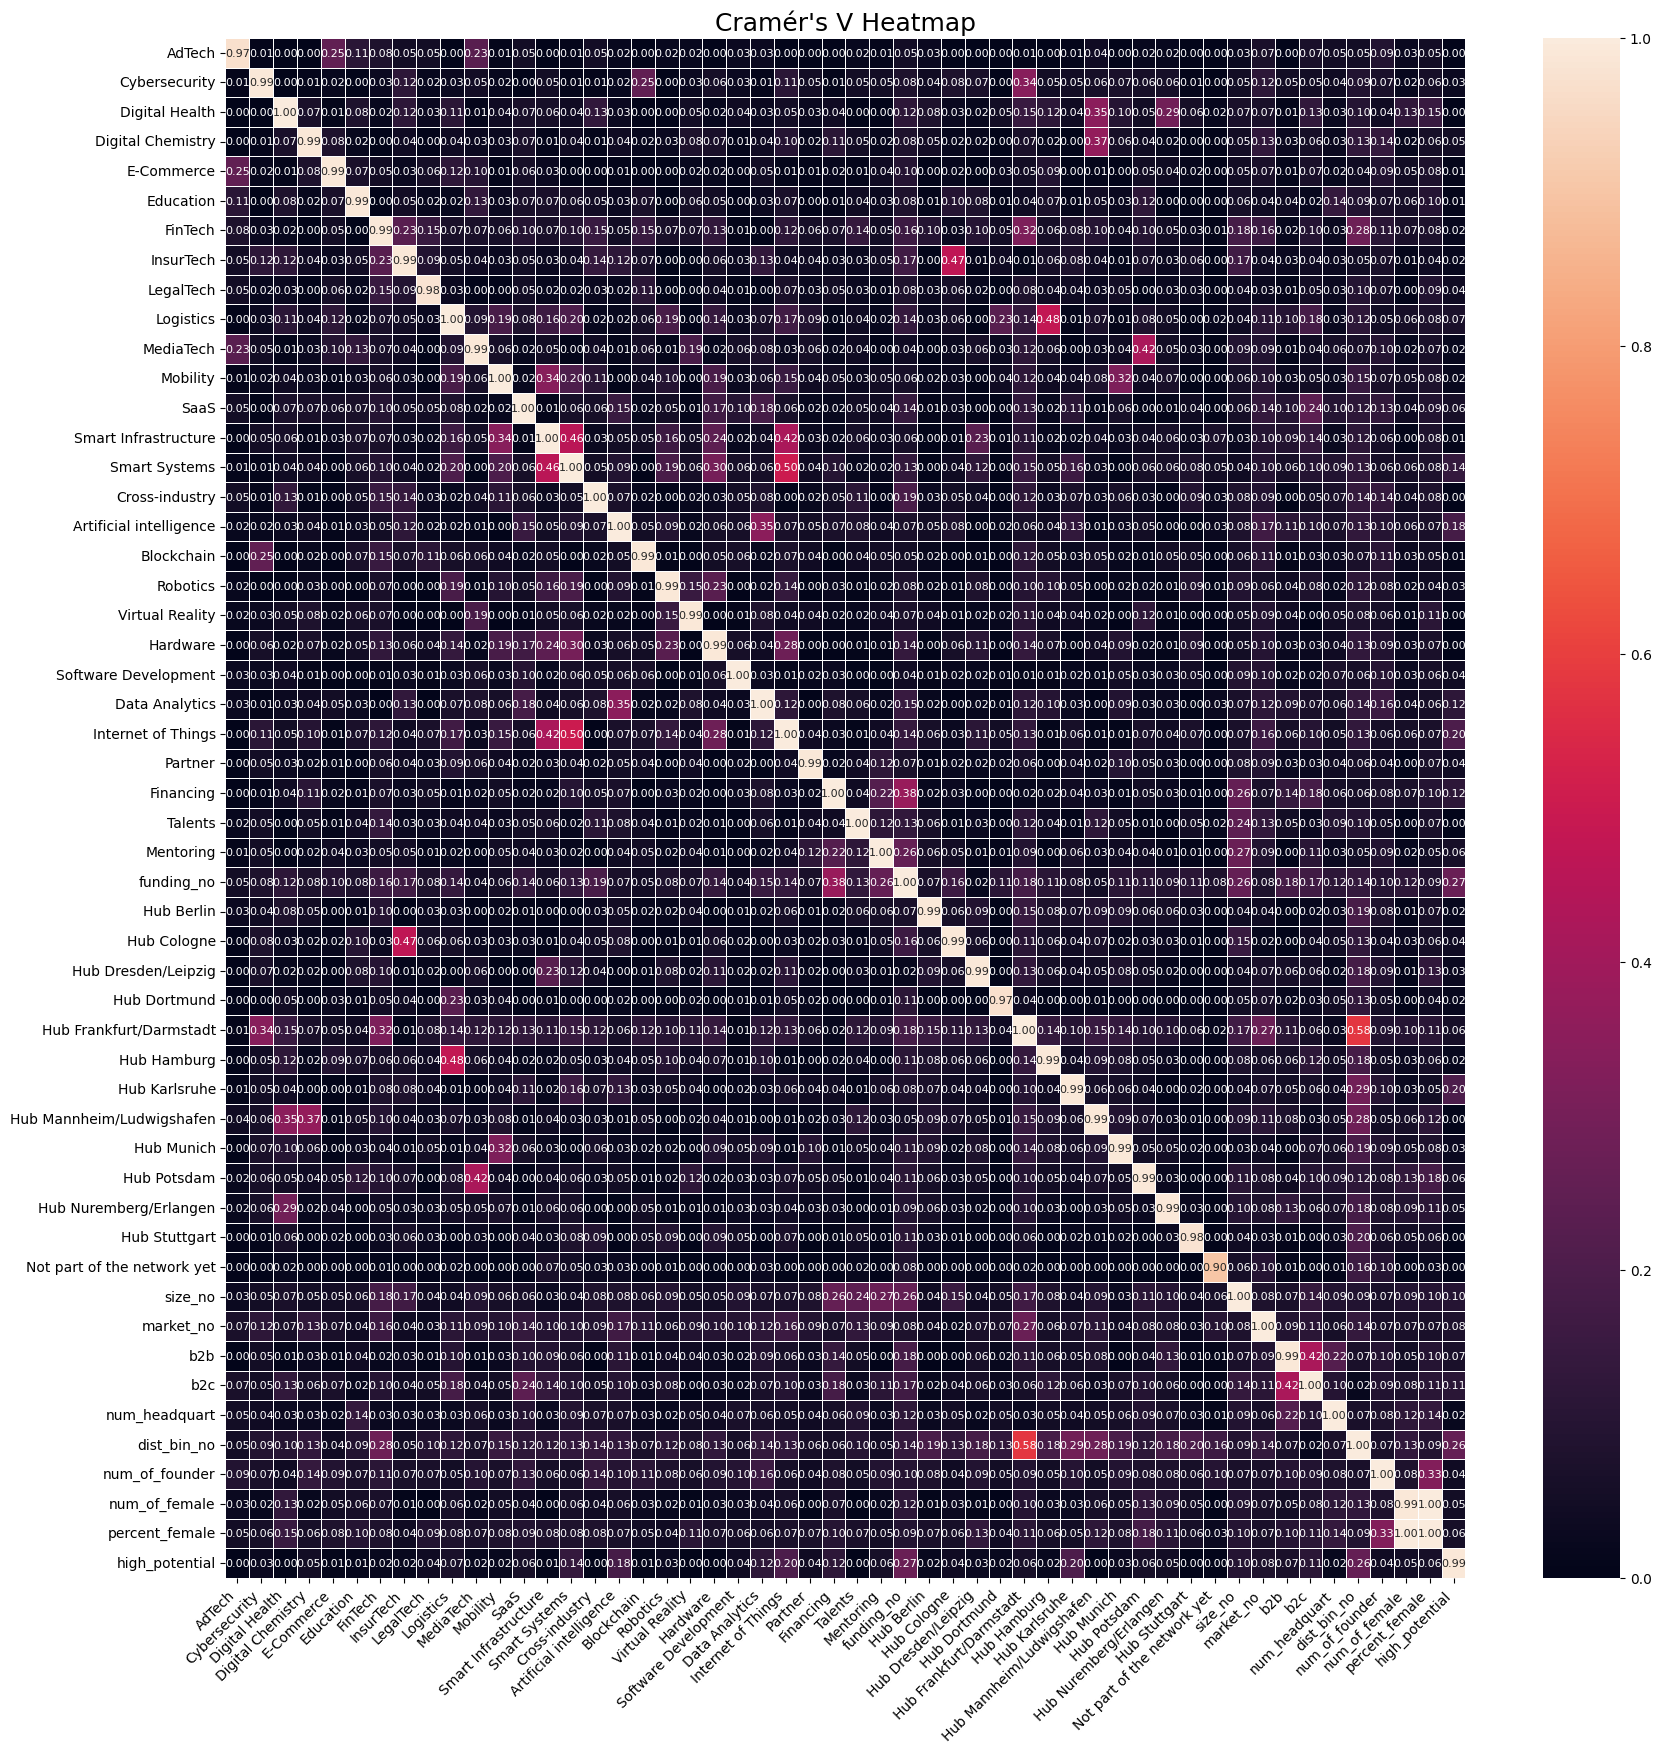

In [13]:
#heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(df1, annot=True, annot_kws={"size": 8}, fmt=".2f", linewidths=0.5)
plt.title("Cramér's V Heatmap", fontsize=18)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Cramer’s V values for this dataset range from 0 to 0.23, showing very weak associations between features (as the maximum possible Cramer’s V is 1).

Strongest associations:
1. Smart Systems - Internet of Things: 0.23
2. InsurTech - Hub Cologne: 0.22
3. Hub Hamburg - Logistics: 0.22

# Contingency Matrix

Contigency Coefficient is another metric to capture associations between variables. As Cramer's V numbers are pretty low, I would like to test with another metric to better see the relationships

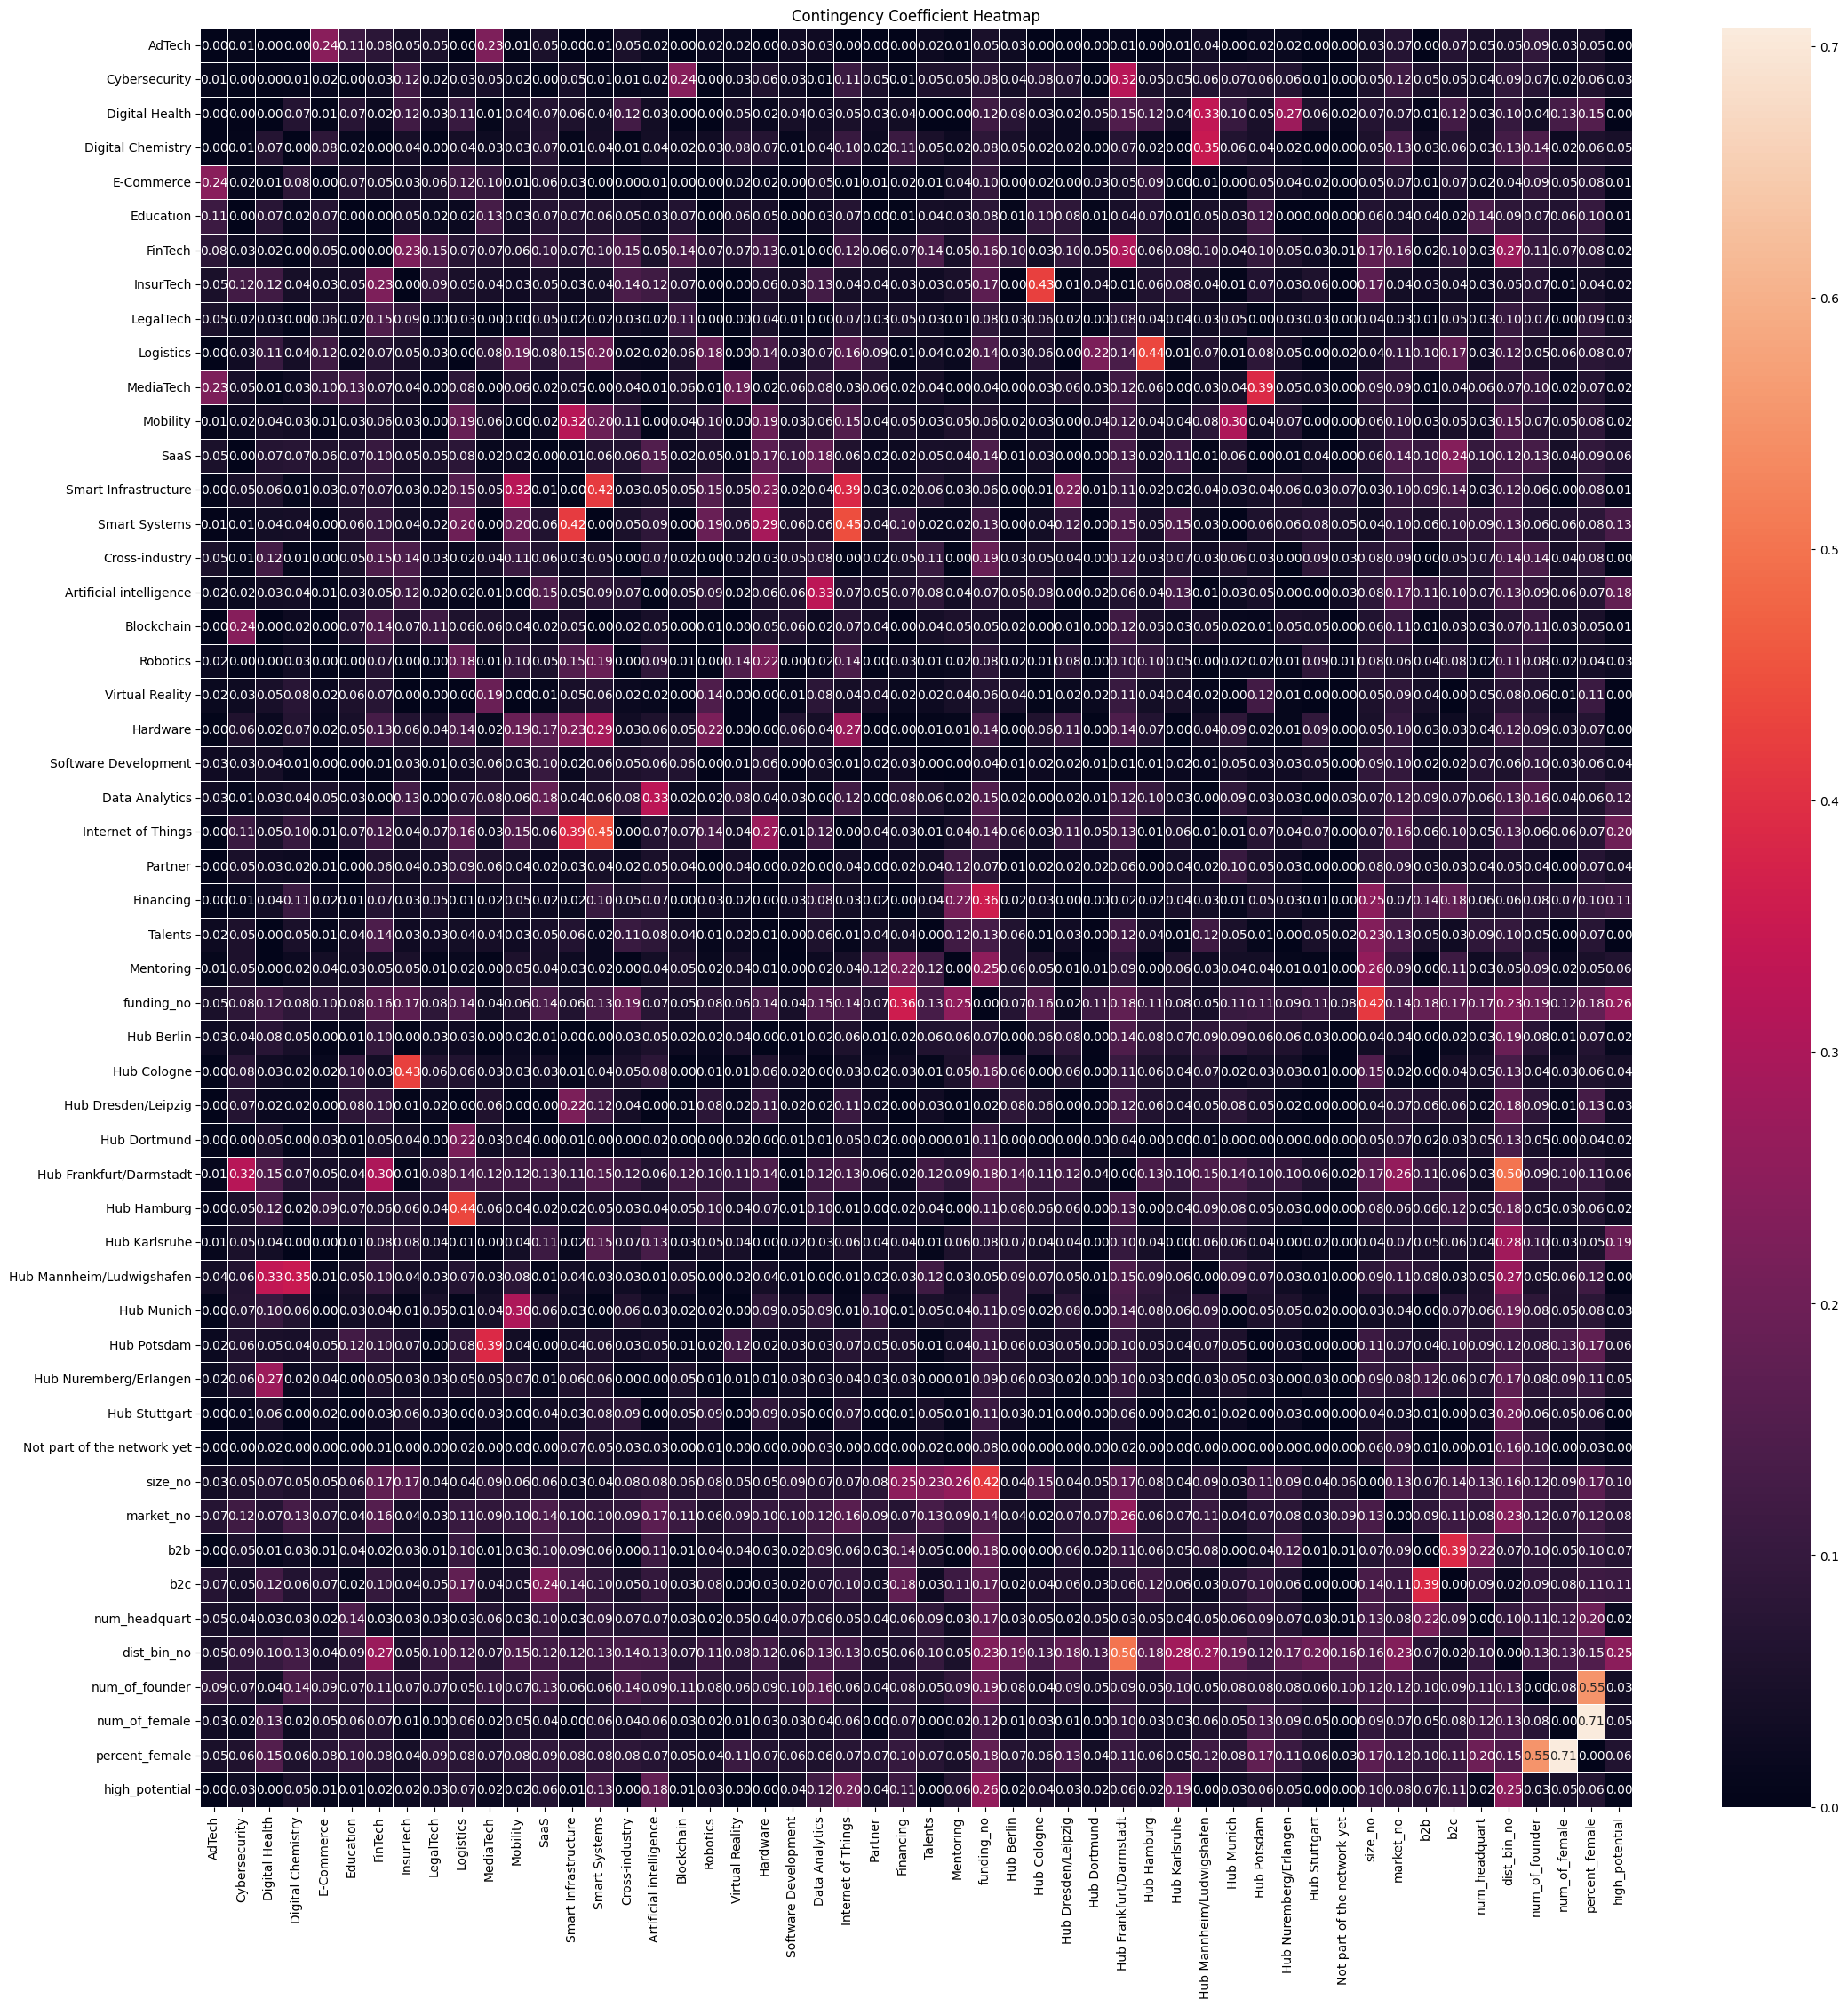

In [14]:
contingency_matrix = np.zeros((num_vars, num_vars))

for i, var1 in enumerate(cate_col.columns):
    for j, var2 in enumerate(cate_col.columns):
        if i != j:  # Exclude the same variables
            contingency_table = pd.crosstab(cate_col[var1], cate_col[var2])
            chi2, _, _, _ = chi2_contingency(contingency_table)
            contingency_coefficient = np.sqrt(chi2 / (chi2 + len(cate_col)))  # Calculate the contingency coefficient
            contingency_matrix[i, j] = contingency_coefficient


contingency_df = pd.DataFrame(contingency_matrix, columns=cate_col.columns, index=cate_col.columns)

plt.figure(figsize=(num_vars // 2, num_vars // 2))

sns.heatmap(contingency_df, annot=True, fmt=".2f", linewidths=.5)

plt.title("Contingency Coefficient Heatmap")
plt.show()

Contingency coefficients seem to capture the strength of relationships more clearly and sensitively than Cramer’s V for this dataset.

Maximum contingency coefficient observed is 0.43, indicating moderate correlation strength. So, overall, there is low association between variables, with some exceptions.

Some patterns from the high associations:
1.  Overlap in industries and technologies`:
Industries/technologies that overlap in real applications show higher associations:
- Smart Infrastructure, Smart Systems, and Internet of Things are closely related.
- MediaTech - AdTech - E-commerce
- Logistics - Mobility
- MediaTech - Virtual Reality
- SaaS - Software Development

2. `Digital hubs and their technology expertise`:
Some hubs show strong associations with specific technologies, inferring that these are the core focus at the hub:
- Hub Mannheim/Ludwigshafen with Digital Health (0.32) and Digital Chemistry (0.35)
- Hub Potsdam with MediaTech (0.39)
- Hub Hamburg with Logistics (0.43)

3. `Startup needs are highly linked with each other`:
Startup needs tend to highly depend on each other. For example, a startup with financing needs are also looking for partners, talents, or mentorship.
* Startups in Hub Frankfurt/Darmstadt show strong associations across many elements, reflecting diversity in industries and expertise alongside a large startup ecosystem here. This can be the most diverse and active hub.

4. `Target variable associations`:
Highest associations with:
- Funding phase (0.35)
- IoT technology (0.28)
- Financing needs (0.19)
- Startup size (0.18) 

These are likely the most important factors to evaluate a startup's potential for partnership in this case, though the directions are not clear as negative or positive.

# Feature Selection

Too many irrelevant features entering the model can cause a lot of noise. Therefore, I will use Chi-squared metric to select only features that are influential on the target variable. 

In [15]:
from sklearn.feature_selection import chi2
X = df.drop(columns=['high_potential'])
y = df['high_potential']

#Use chi-squared to examine the association of
chi_scores, p_values = chi2(X, y)
chi2_df = pd.DataFrame({'Feature': X.columns, 'Chi2': chi_scores, 'P-value': p_values})
chi2_df = chi2_df.sort_values(by=['P-value'], ascending=True)

chi_values = pd.Series(chi_scores, index=X.columns)
chi_values.sort_values(ascending=True, inplace=True)
chi2_df


,Feature,Chi2,P-value
48,dist_A,1.167213e+02,3.303755e-27
52,percent_female,7.218428e+01,1.960114e-17
34,Hub Karlsruhe,2.957173e+01,5.388526e-08
23,Internet of Things,2.377746e+01,1.081417e-06
45,funding_no,1.893362e+01,1.353465e-05
16,Artificial intelligence,1.242812e+01,4.229169e-04
14,Smart Systems,1.159677e+01,6.606629e-04
43,b2c,6.921842e+00,8.514921e-03
22,Data Analytics,5.903370e+00,1.511194e-02
49,dist_bin_no,3.896938e+00,4.837421e-02


The Chi-square test checks for significant associations between categorical variables; a p-value under 0.05 indicates a strong association unlikely due to chance.

Out of 53 variables, `only 9 showed a statistically significant association` (p-value < 0.05) with the target (high-potential startups).

These 9 variables are:
- Distance to the company (categorized)
- Percentage of females in leadership
- Startups from Hub Karlsruhe
- Funding stage
- B2C business type
- Operating in smart systems industries
- Technology expertise in IoT
- Technology expertise in AI
- Technology expertise in DA

These variables were selected for modeling.

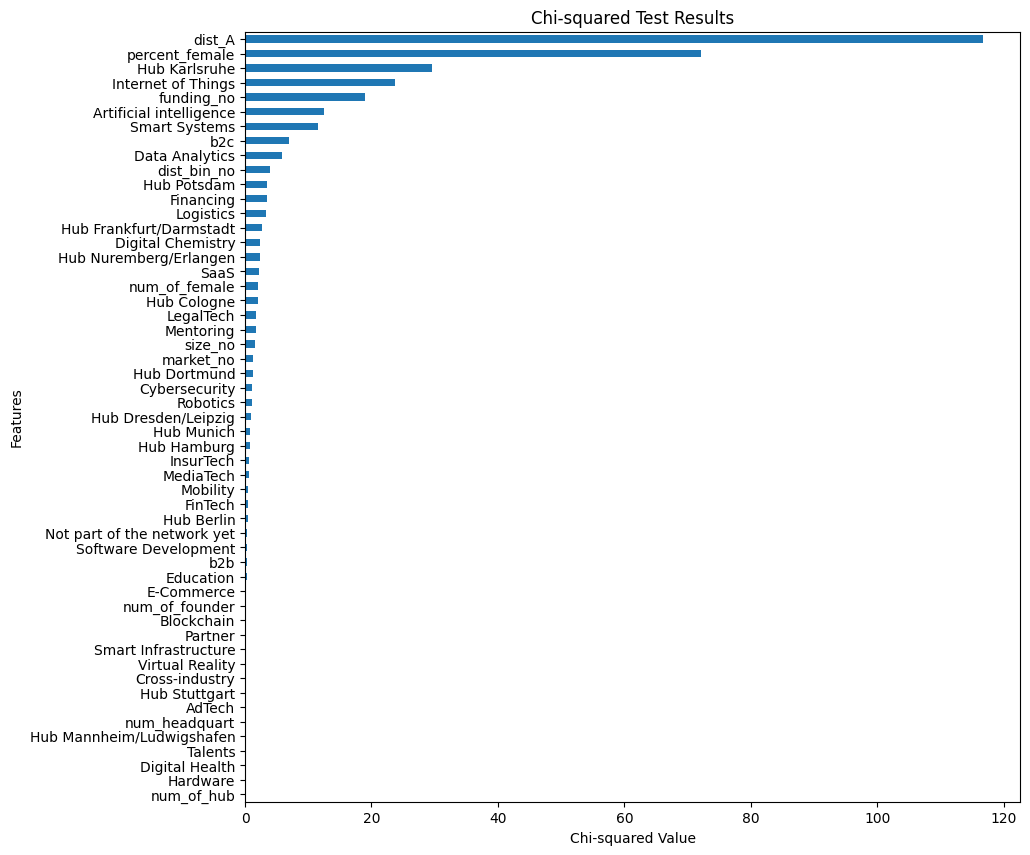

In [16]:
#plot chi2
plt.figure(figsize=(10, 10))
chi_values.plot.barh()
plt.xlabel('Chi-squared Value')
plt.ylabel('Features')
plt.title('Chi-squared Test Results')
plt.show()

In [50]:
df_feature_selection = df[['percent_female', 'Internet of Things','funding_no',
                           'Artificial intelligence','Smart Systems', 'Hub Karlsruhe',
                           'b2c', 'Data Analytics', 'dist_bin_no' ]]

df_feature_selection['high_potential'] = df['high_potential']



C:\Users\Admin\AppData\Local\Temp\ipykernel_42316\1026734133.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_selection['high_potential'] = df['high_potential']


# PCA

Among the variables, the 2 pairs of IoT with Smart Systems and DA with AI technologies show great association with each other. To ensure there is no multicollinearity, I use PCA to combine each pair into 1 feature only, avoiding overlap effects. \
IoT and Smart Systems -> IoT_SmartSystems_PC1 \
DA and AI -> AI_DataAnalytics_PC2

In [18]:
# Extract feature groups
features_to_pca_1 = df_feature_selection[['Internet of Things', 'Smart Systems']]
features_to_pca_2 = df_feature_selection[['Data Analytics', 'Artificial intelligence']]
other_features = df_feature_selection.drop(
    columns=['Internet of Things', 'Smart Systems', 'Data Analytics', 'Artificial intelligence', 'high_potential']
)

# PCA for first pair: Internet of Things + Smart Systems
pca_1 = PCA(n_components=1)
pc1_values = pca_1.fit_transform(features_to_pca_1)

# Flip sign if sum of loadings is negative (optional rule)
if pca_1.components_[0].sum() < 0:
    pc1_values *= -1
    pca_1.components_ *= -1

pca_df_1 = pd.DataFrame(pc1_values, columns=['IoT_SmartSystems_PC1'])

# PCA for second pair: Data Analytics + AI
pca_2 = PCA(n_components=1)
pc2_values = pca_2.fit_transform(features_to_pca_2)

# Flip sign if sum of loadings is negative (e.g., if both DA and AI are positively correlated with the outcome)
if pca_2.components_[0].sum() < 0:
    pc2_values *= -1
    pca_2.components_ *= -1

pca_df_2 = pd.DataFrame(pc2_values, columns=['AI_DataAnalytics_PC2'])

# Final dataset
df_final = pd.concat(
    [other_features, pca_df_1, pca_df_2, df_feature_selection[['high_potential']]],
    axis=1
)

print(df_final.head())


   percent_female  funding_no  Hub Karlsruhe  b2c  dist_bin_no  \
0               0           3              0    0            1   
1               0           3              0    0            1   
2               0           3              1    0            4   
3               0           2              0    1            3   
4               0           1              0    0            3   

   IoT_SmartSystems_PC1  AI_DataAnalytics_PC2  high_potential  
0             -0.356631             -0.015485               0  
1             -0.356631             -0.721098               0  
2              0.317886             -0.015485               0  
3             -0.356631             -0.012502               0  
4             -0.356631             -0.721098               0  


In [20]:
df_feature_selection = df_final

## Negative labeling (Clustering)

The study uses a weak supervision - Clustering approach to generate negative labels due to me only having positive samples.

Basically, I will group the startups (with all of their features and dimensions) into different clusters.  `Clusters with no or very few positive cases (max 5%) are labeled as negative samples, assuming startups that are very different to the chosen candidates (positive samples) are actual negatives`.

In [21]:
#Scale features before clustering
features = [col for col in df_feature_selection.columns if col != 'high_potential']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_feature_selection[features])
X_scaled_df = pd.DataFrame(X_scaled, columns=features)


In [22]:
#Clustering
kmeans = KMeans(n_clusters=15, random_state=42)
df_feature_selection['cluster'] = kmeans.fit_predict(X_scaled)

#choose clusters that DON'T INCLUDE any positive sample
partner_clusters = df_feature_selection[df_feature_selection['high_potential'] == 1]['cluster'].unique()
negative_pool = df_feature_selection[(df_feature_selection['high_potential'] == 0) & (~df_feature_selection['cluster'].isin(partner_clusters))]

len(negative_pool) #=66 negative samples only -> too little

c:\Users\Admin\Documents\Studio Code\col\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


152

In [23]:
#relax the condition: get clusters also for those that have little positive:negative sample ratio
cluster_counts = df_feature_selection.groupby('cluster')['high_potential'].value_counts().unstack().fillna(0)
cluster_counts['positive_ratio'] = cluster_counts[1] / (cluster_counts[0] + cluster_counts[1])

# Keep clusters where MOST samples are NOT positive (6%)
safe_clusters = cluster_counts[cluster_counts['positive_ratio'] < 0.05].index

negative_pool = df_feature_selection[(df_feature_selection['high_potential'] == 0) & (df_feature_selection['cluster'].isin(safe_clusters))]
len(negative_pool)


501

In [24]:
positive_samples = df_feature_selection[df_feature_selection['high_potential'] == 1]
balanced_df = pd.concat([positive_samples, negative_pool]).reset_index(drop=True)
balanced_df

,percent_female,funding_no,Hub Karlsruhe,b2c,dist_bin_no,IoT_SmartSystems_PC1,AI_DataAnalytics_PC2,high_potential,cluster
0,0,3,1,0,3,0.381629,0.693112,1,5
1,0,3,0,0,4,-0.356631,-0.015485,1,3
2,0,1,1,0,3,1.056146,0.693112,1,5
3,0,4,0,0,3,1.056146,-0.015485,1,6
4,0,4,0,0,3,0.381629,-0.015485,1,6
...,...,...,...,...,...,...,...,...,...
549,0,4,0,1,4,-0.356631,-0.015485,0,0
550,0,2,0,0,4,-0.356631,-0.012502,0,9
551,0,1,0,0,4,-0.356631,0.693112,0,9
552,50,1,0,0,4,1.056146,-0.721098,0,10


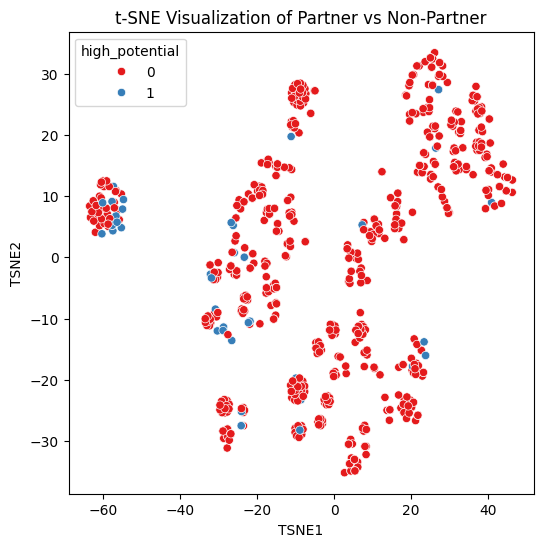

In [25]:
#Visualize clusters
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

df['TSNE1'] = X_tsne[:, 0]
df['TSNE2'] = X_tsne[:, 1]

plt.figure(figsize=(6,6))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='high_potential', palette='Set1')
plt.title("t-SNE Visualization of Partner vs Non-Partner")

plt.show()

### Load packages for Modelling & Preparation

In [44]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, make_scorer, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


### Remove duplicates


To make sure there is no data leakage between the train and the test dataset, I have to remove duplicates

In [27]:
# Drop cluster column
balanced_df = balanced_df.drop(columns=['cluster'], errors='ignore')

#Remove dups = dedup_df
dedup_df = balanced_df.drop_duplicates()

# Sample test set from deduplicated positives and negatives
positives = dedup_df[dedup_df['high_potential'] == 1]
negatives = dedup_df[dedup_df['high_potential'] == 0]

n_pos_test = 30 #wanted positives in test set
n_neg_test = 70 #wanted negatives
test_pos = positives.sample(n=n_pos_test, random_state=42)
test_neg = negatives.sample(n=n_neg_test, random_state=42)

df_test = pd.concat([test_pos, test_neg]).reset_index(drop=True) #--> Test set

# Drop all rows in balanced_df that are exact matches with df_test (based on all columns)
join_cols = balanced_df.columns.tolist()
df_train = balanced_df.merge(df_test, on=join_cols, how='outer', indicator=True)
df_train = df_train[df_train['_merge'] == 'left_only'].drop(columns=['_merge']) #take the rest excluding those from test set

# Rebuild X/y
X_train = df_train.drop(columns=['high_potential'])
y_train = df_train['high_potential']
X_test = df_test.drop(columns=['high_potential'])
y_test = df_test['high_potential']


In [28]:
dedup_df['high_potential'].value_counts()

high_potential
0    201
1     41
Name: count, dtype: int64

As seen above, there is heavy class imbalance in the dataset (202:41), so I have to handle this by applying SMOTE (combining between oversampling and undersampling of class)

## Handle Class Imbalance (SMOTE)

In [34]:
#Smote
sm = SMOTE(sampling_strategy='minority', random_state=42) #define smote
oversampled_X, oversampled_Y = sm.fit_resample(X_train, y_train) #fit SMOTE model to df_train

oversampled = pd.concat([
    pd.DataFrame(oversampled_Y, columns=['high_potential']),
    pd.DataFrame(oversampled_X, columns=X_train.columns)
], axis=1).reset_index(drop=True)

#leakage check
leakage_rows = pd.merge(
    X_test.reset_index(drop=True),
    pd.DataFrame(oversampled_X, columns=X_train.columns),
    how='inner'
)

oversampled_Y.value_counts()


high_potential
0    330
1    330
Name: count, dtype: int64

## Modelling

### Logistic Regression (LR)

In [35]:
#threshold 0.5

model = LogisticRegression(random_state=42) #model: LR that applied after SMOTE
model.fit(oversampled_X, oversampled_Y)

y_pred = model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.859     0.957     0.905        70
           1      0.864     0.633     0.731        30

    accuracy                          0.860       100
   macro avg      0.861     0.795     0.818       100
weighted avg      0.860     0.860     0.853       100



Focusing on class '1' (the potential partners), I see that:
1. `Precision is high (86.4%)`: Every time the model classify a startup as 'potential', it has a 86% chance of being correct -> Solid!
2. `Recall is low (63.3%)`: Out of all the startups out there, it can detect only 63% of them. 

In this case of selecting partners, I consider `Precision to be more important`, as we do not need to detect every single startups on the market. The final outcome only requires 1 startup that makes it to the final round, so the accuracy of making sure we pick the right, suitable and truly potential venture should be more important. 

# Other models

In [ ]:
# Choose models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(oversampled_X, oversampled_Y)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # For ROC-AUC

    # Metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, pos_label=1, average='binary')
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results.append({
        "Model": name,
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1-Score": round(f1, 3),
        "Accuracy": round(accuracy, 3),
        "ROC-AUC": round(roc_auc, 3)
    })

# Results as DataFrame
results_df = pd.DataFrame(results).set_index("Model")
display(results_df)


c:\Users\Admin\Documents\Studio Code\col\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:45:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Precision,Recall,F1-Score,Accuracy,ROC-AUC
Model,,,,,
Logistic Regression,0.760,0.633,0.691,0.83,0.865
Random Forest,0.923,0.400,0.558,0.81,0.870
XGBoost,0.850,0.567,0.680,0.84,0.853
SVM,0.826,0.633,0.717,0.85,0.855


Using Logistic Regression as a benchmark, we can see:
1. `Random Forest` is the `best model` (with the `highest Precision` - 92.3%)
2. LR is the model with lowest performance regarding Precision
3. If we want a more `balanced` approach - balancing the precision of each guess and the amount of startups being detected - we should go with `SVM (71.1% for F1-score)`. 

c:\Users\Admin\Documents\Studio Code\col\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:38:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                     Best Threshold  Precision  Recall  F1-Score  Accuracy  \
Model                                                                        
Logistic Regression            0.38      0.815   0.733     0.772      0.87   
Random Forest                  0.05      0.684   0.867     0.765      0.84   
XGBoost                        0.02      0.722   0.867     0.788      0.86   
SVM                            0.38      0.840   0.700     0.764      0.87   

                     ROC-AUC  
Model                         
Logistic Regression    0.876  
Random Forest          0.892  
XGBoost                0.890  
SVM                    0.869  


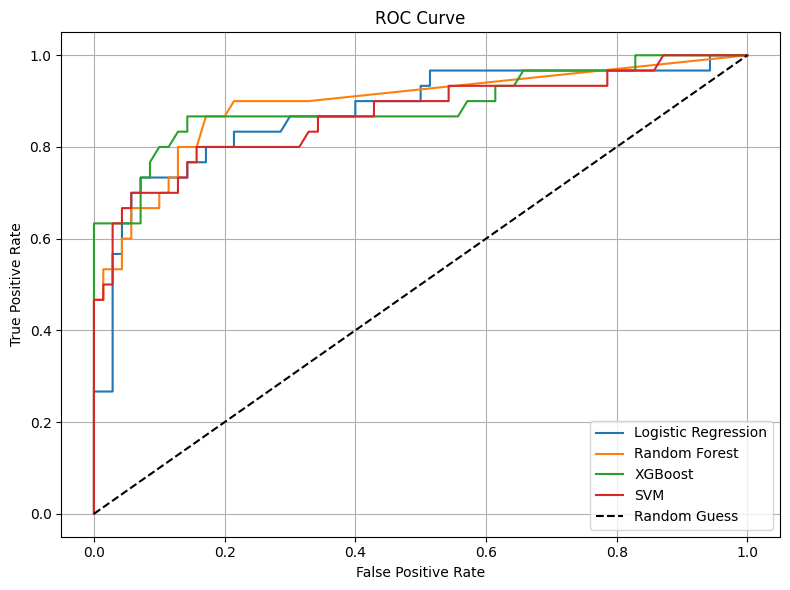

In [45]:

models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

metrics_summary = []
roc_curves = {}
pr_curves = {}

# Train and compute metrics
for name, model in models.items():
    model.fit(oversampled_X, oversampled_Y)
    probs = model.predict_proba(X_test)[:, 1]

    # ROC and PR curves
    fpr, tpr, _ = roc_curve(y_test, probs)
    precision, recall, thresholds = precision_recall_curve(y_test, probs)

    # Best F1 threshold
    f1s = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1s)
    best_thresh = thresholds[best_idx]
    best_f1 = f1s[best_idx]

    # Predict at best threshold
    final_preds = (probs >= best_thresh).astype(int)

    # Metrics
    prec = precision_score(y_test, final_preds, zero_division=0)
    rec = recall_score(y_test, final_preds, zero_division=0)
    auc = roc_auc_score(y_test, probs)
    acc = accuracy_score(y_test, final_preds)

    # Store results
    metrics_summary.append({
        "Model": name,
        "Best Threshold": round(best_thresh, 2),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1-Score": round(best_f1, 3),
        "Accuracy": round(acc, 3),
        "ROC-AUC": round(auc, 3)
    })

    roc_curves[name] = (fpr, tpr)
    pr_curves[name] = (recall, precision)

metrics_df = pd.DataFrame(metrics_summary).set_index("Model")
print(metrics_df)

# Plot ROC curves
plt.figure(figsize=(8, 6))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Overall, the ROC-AUC between models don't show much of a gap. Therefore, the overall classfication power across different thresholds of all models remain relatively indifferent. 

# Validation

Cross-validation to make sure the results attained before is reliable.

In [48]:
# Set data
X = balanced_df.drop(columns=['high_potential'])
y = balanced_df['high_potential']

# Settings
n_repeats = 5
threshold = 0.7

# Store metrics
all_metrics = {
    'Run': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'ROC-AUC': []
}

for i in range(n_repeats):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42 + i
    )

    # SMOTE on training 
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    #Train
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_res, y_train_res)

    # Predict
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    # Evaluate
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba)

    all_metrics['Run'].append(i + 1)
    all_metrics['Precision'].append(prec)
    all_metrics['Recall'].append(rec)
    all_metrics['F1-score'].append(f1)
    all_metrics['ROC-AUC'].append(roc)

df_metrics = pd.DataFrame(all_metrics)

summary = pd.DataFrame({
    'Run': ['Mean', 'Std Dev'],
    'Precision': [df_metrics['Precision'].mean(), df_metrics['Precision'].std()],
    'Recall': [df_metrics['Recall'].mean(), df_metrics['Recall'].std()],
    'F1-score': [df_metrics['F1-score'].mean(), df_metrics['F1-score'].std()],
    'ROC-AUC': [df_metrics['ROC-AUC'].mean(), df_metrics['ROC-AUC'].std()],
})

df_metrics = pd.concat([df_metrics, summary], ignore_index=True)

df_metrics



,Run,Precision,Recall,F1-score,ROC-AUC
0,1,0.750000,0.818182,0.782609,0.890000
1,2,0.642857,0.818182,0.720000,0.918182
2,3,0.700000,0.636364,0.666667,0.911818
3,4,0.500000,0.545455,0.521739,0.900455
4,5,1.000000,0.818182,0.900000,0.963636
5,Mean,0.718571,0.727273,0.718203,0.916818
6,Std Dev,0.183058,0.128565,0.140050,0.028310
